# 3. PyTorch Basics - Writing a PyTorch Neural Network with Backprop and Training

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (27/12/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)
- Time
- Torch (tested on v1.13.0)

### Imports and CUDA

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Numpy
import numpy as np
from numpy.random import default_rng
# OS
import os
# Pickle
import pickle
# Time
from time import time
# Torch
import torch

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Mock dataset, with nonlinearity

As in the previous notebooks, we will reuse our nonlinear binary classification mock dataset and generate a training set with 1000 samples, a test set with 100 samples and a validation set with 100 samples.

In [3]:
# All helper functions
eps = 1e-5
min_val = -1 + eps
max_val = 1 - eps
def val(min_val, max_val):
    return round(np.random.uniform(min_val, max_val), 2)
def class_for_val(val1, val2):
    k = np.pi
    return int(val2 >= -1/4 + 3/4*np.sin(val1*k))
def create_dataset(n_points, min_val, max_val):
    val1_list = np.array([val(min_val, max_val) for _ in range(n_points)])
    val2_list = np.array([val(min_val, max_val) for _ in range(n_points)])
    inputs = np.array([[v1, v2] for v1, v2 in zip(val1_list, val2_list)])
    outputs = np.array([class_for_val(v1, v2) for v1, v2 in zip(val1_list, val2_list)]).reshape(n_points, 1)
    return val1_list, val2_list, inputs, outputs

In [4]:
# Generate dataset (train)
np.random.seed(47)
n_points = 1000
train_val1_list, train_val2_list, train_inputs, train_outputs = create_dataset(n_points, min_val, max_val)
# Generate dataset (test)
np.random.seed(17)
n_points_test = 100
test_val1_list, test_val2_list, test_inputs, test_outputs = create_dataset(n_points_test, min_val, max_val)
# Generate dataset (valid)
np.random.seed(27)
n_points_valid = 100
valid_val1_list, valid_val2_list, valid_inputs, valid_outputs = create_dataset(n_points_valid, min_val, max_val)

In [5]:
# Convert to tensors and send to device (CUDA or CPU)
train_inputs_pt = torch.from_numpy(train_inputs).to(device)
train_outputs_pt = torch.from_numpy(train_outputs).to(device)
test_inputs_pt = torch.from_numpy(test_inputs).to(device)
test_outputs_pt = torch.from_numpy(test_inputs).to(device)
valid_inputs_pt = torch.from_numpy(valid_inputs).to(device)
valid_outputs_pt = torch.from_numpy(valid_inputs).to(device)

### Gradient Descent in PyTorch

What makes PyTorcdh extremely powerful is the autograd, a computational graph able to provide automatic differentiation for all operations on Tensors.

For instance, let us consider the function $f(x) = (x-2)^2$.

Compute $\frac{d}{dx} f(x)$ and then compute $f'(1)$.

The automatic differentiation is done by PyTorch automatically, for any tensor, that has been tracked by setting its attribute **requires_grad** to **True**.

Any operation involving this tensor can then be tracked back by using the **backward()** method on the resulting variable variable (here, **y**) in the computation, computing all the gradients of **y** at once.

Let us see it at work below!

In [6]:
# Our function f
def f(x):
    return (x-2)**2

# Its differentiation
def fp(x):
    return 2*(x-2)

# Let us create a tensor with  single value, 1.0
# We make its attribute requires_grad = True.
# This allows to track all operations on the tensor. 
x = torch.tensor([1.0], requires_grad = True)

# Compute the value of f(1)
y = f(x)

# Backward methods will compute the gradient of the operations using x
# Here, this computes the gradient of given tensors y with respect to x.
y.backward() 

# Compare the theoretical value of fp(1)...
print('Theoretical f\'(x):', fp(x))
# ... to the one calculated by PyTorch!
print('PyTorch\'s Value of f\'(x):', x.grad)

Theoretical f'(x): tensor([-2.], grad_fn=<MulBackward0>)
PyTorch's Value of f'(x): tensor([-2.])


It can also find gradients of functions of multiple variables!

For instance let $ w = [w_0, w_1]^T $ be a 1D tensor and consider the function

$$ g(w) = 2w_0w_1 + w_1\cos(w_0) $$.

We can use the autograd to compute $ \nabla_w g(w) $ and verify that $ \nabla_w g(\pi,1) = (2, \pi - 1) $

In [7]:
# Our function g
def g(w):
    return 2*w[0]*w[1] + w[1]*torch.cos(w[0])

# Theoretical gradient (derived manually)
def grad_g(w):
    # Returns a 1D tensor with two values, being the
    # differentiation wrt to w0 and w1 respectively
    return torch.tensor([2*w[1] - w[1]*torch.sin(w[0]),\
                         2*w[0] + torch.cos(w[0])])


# Create 1D tensor with two values pi and 1.
# Set requires_grad flag to True for autograd
w = torch.tensor([np.pi, 1], requires_grad = True)

# "Forward" pass on our fucntion g
z = g(w)

# "Backward" pass to compute all gradients
z.backward()

# Compare the theoretical value of fp(1)...
print('Theoretical gradient of g(w)', grad_g(w))
# ... to the one calculated by PyTorch!
print('PyTorch\'s Value for gradient of g(w)', w.grad)

Theoretical gradient of g(w) tensor([2.0000, 5.2832])
PyTorch's Value for gradient of g(w) tensor([2.0000, 5.2832])


### Using the autograd for automating the gradient descent rules

This autograd is the key component of PyTorch, and why we like it so much.

This basically means that we do not need to calculate the gradients for any of our future gradient descent rules, manually again!

The counterpart however is that all operation must involve tensors and must use PyTorch functions and methods... (but that is ok).

You do not need to know how it implements the computation of all gradients in the background, but if you are curious, have a look at this: https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/

Now that we have an automated way to compute gradients, we can use gradient descent to find the (local) minima of any differentiable function. To demonstrate, let $ f $ be the same function we defined above, i.e. $f(x) = (x-2)^2$.

We will find the minimum by using the gradient descent algorithm, whose steps are:
- Define a starting point $ x_0 $ and learning rate $ \alpha $ and set $ t $ to $ 0 $.
- Forward pass: compute $f'(x_t)$
- Backward pass: $ x_{t+1} = x_t - \alpha f'(x_t) $
- Increment $ t $ by 1, and repeat forward-backward passes for a given number of iterations or until convergence is observed.

We demonstrate how it is done below.

In [8]:
# Initialize x to the value 5 (i.e. x_0 = 5).
# It will be a 1D tensor with a single value again.
x = torch.tensor([5.0], requires_grad=True)

# Set alpha to 0.25
alpha = 0.25

# Prepare display
print('iter,\tx,\tf(x),\tf\'(x),\tf\'(x) pytorch')

# Repeat iterations of gradient descent over 15 iterations
for i in range(20):
    # Forward pass
    y = f(x)
    
    # Backward pass
    y.backward()
    # Note x.data consists of all the data in the tensor.
    # Here, this is equivalent to x[0].
    x.data = x.data - alpha * x.grad
     
    # Display
    # Note: using .item() on a tensor element or tensor with single values
    # gives you the value of said elements/tensor in dtype (here, float).
    print('{},\t{:.3f},\t{:.3f},\t{:.3f},\t{:.3f}'.format(i, x.item(), f(x).item(), fp(x).item(), x.grad.item()))
    
    # This basically resets the gradients in x,
    # now that they have been used so that the next forward pass
    # is not getting the gradients mixed with the previous one.
    x.grad.zero_()
    
print("Local minima found at:", x.item())

iter,	x,	f(x),	f'(x),	f'(x) pytorch
0,	3.500,	2.250,	3.000,	6.000
1,	2.750,	0.562,	1.500,	3.000
2,	2.375,	0.141,	0.750,	1.500
3,	2.188,	0.035,	0.375,	0.750
4,	2.094,	0.009,	0.188,	0.375
5,	2.047,	0.002,	0.094,	0.188
6,	2.023,	0.001,	0.047,	0.094
7,	2.012,	0.000,	0.023,	0.047
8,	2.006,	0.000,	0.012,	0.023
9,	2.003,	0.000,	0.006,	0.012
10,	2.001,	0.000,	0.003,	0.006
11,	2.001,	0.000,	0.001,	0.003
12,	2.000,	0.000,	0.001,	0.001
13,	2.000,	0.000,	0.000,	0.001
14,	2.000,	0.000,	0.000,	0.000
15,	2.000,	0.000,	0.000,	0.000
16,	2.000,	0.000,	0.000,	0.000
17,	2.000,	0.000,	0.000,	0.000
18,	2.000,	0.000,	0.000,	0.000
19,	2.000,	0.000,	0.000,	0.000
Local minima found at: 2.000002861022949


### Rewriting our class using PyTorch operations instead of Numpy - Backpropagation and training

In order to train our Neural Network, we will relmy on the power of the autograd to compute the gradient update for us automatically.

For this reason,
- there is no need for a **backward()** method as before (covered by PyTorch!),
- our **train()** method will consist of several iterations of forward pass, gradient computation with backward() and gradient descent update on parameters.

We implement it below.

In [9]:
# Our class will inherit from the torch.nn.Module
# used to write all model in PyTorch
class ShallowNeuralNet_PT(torch.nn.Module):
    
    def __init__(self, n_x, n_h, n_y):
        # Super __init__ for inheritance
        super().__init__()
        
        # Network dimensions (as before)
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        
        # Initialize parameters using the torch.nn.Parameter type (a subclass of Tensors).
        # We immediatly initialize the parameters using a random normal.
        # The RNG is done using torch.randn instead of the NumPy RNG.
        # We add a conversion into float64 (the same float type used by Numpy to generate our data)
        # And send them to our GPU/CPU device
        self.W1 = torch.nn.Parameter(torch.randn(n_x, n_h, requires_grad = True, \
                                     dtype = torch.float64, device = device)*0.1)
        self.b1 = torch.nn.Parameter(torch.randn(1, n_h, requires_grad = True, \
                                     dtype = torch.float64, device = device)*0.1)
        self.W2 = torch.nn.Parameter(torch.randn(n_h, n_y, requires_grad = True, \
                                     dtype = torch.float64, device = device)*0.1)
        self.b2 = torch.nn.Parameter(torch.randn(1, n_y, requires_grad = True, \
                                     dtype = torch.float64, device = device)*0.1)
        self.W1.retain_grad()
        self.b1.retain_grad()
        self.W2.retain_grad()
        self.b2.retain_grad()
        
    def forward(self, inputs):
        # Instead of using np.matmul(), we use its equivalent in PyTorch,
        # which is torch.matmul()!
        # (Most numpy matrix operations ahve their equivalent in torch, check it out!)
        # Wx + b operation for the first layer
        Z1 = torch.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        # Sigmoid is already implemented in PyTorch, feel fre to reuse it!
        A1 = torch.sigmoid(Z1_b)
        
        # Wx + b operation for the second layer
        # (Same as first layer)
        Z2 = torch.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = torch.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, pred, outputs):
        # We will use an epsilon to avoid NaNs on the log() values
        eps = 1e-10
        # As before with matmul, most operations in NumPy have their equivalent in torch (e.g. log and sum)
        losses = outputs * torch.log(pred + eps) + (1 - outputs) * torch.log(1 - pred + eps)
        loss = -torch.sum(losses)/outputs.shape[0]
        return loss
    
    def accuracy(self, pred, outputs):
        # Calculate accuracy for given inputs and ouputs
        # We will, again, rely as much as possible on the torch methods and functions. 
        return ((pred >= 0.5).int() == outputs).float().mean()
    
    def train(self, inputs, outputs, N_max = 1000, alpha = 1):
        # History of losses
        self.loss_history = []
        # Repeat gradient descent procedure for N_max iterations
        for iteration_number in range(1, N_max + 1):
            # Forward pass
            # This is equivalent to pred = self.forward(inputs)
            pred = self(inputs)
            # Compute loss
            loss = self.CE_loss(pred, outputs)
            self.loss_history.append(loss.item())

            # Backpropagate
            # Compute differentiation of loss with respect to all
            # parameters involved in the calculation that have a flag
            # requires_grad = True (that is W2, W1, b2 and b1)
            loss.backward()

            # Update all weights
            # Note that this operation should not be tracked for gradients,
            # hence the torch.no_grad()!
            with torch.no_grad():
                self.W1 -= alpha*self.W1.grad
                self.W2 -= alpha*self.W2.grad
                self.b1 -= alpha*self.b1.grad
                self.b2 -= alpha*self.b2.grad

            # Reset gradients to 0
            self.W1.grad.zero_()
            self.W2.grad.zero_()
            self.b1.grad.zero_()
            self.W2.grad.zero_()
            
            # Display
            if(iteration_number % (N_max//20) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, loss.item()))

In [10]:
# Define a neural network structure
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_pt = ShallowNeuralNet_PT(n_x, n_h, n_y).to(device)
train_pred = shallow_neural_net_pt.train(train_inputs_pt, train_outputs_pt, N_max = 1001, alpha = 5)

Iteration 1 - Loss = 0.6833345916756396
Iteration 51 - Loss = 0.2704784192547984
Iteration 101 - Loss = 0.2690332115428549
Iteration 151 - Loss = 0.2634355294952037
Iteration 201 - Loss = 0.23531335954076793
Iteration 251 - Loss = 0.20209626769784592
Iteration 301 - Loss = 0.17849129591385224
Iteration 351 - Loss = 0.16028245086269
Iteration 401 - Loss = 0.1456567613021914
Iteration 451 - Loss = 0.13378700856081355
Iteration 501 - Loss = 0.1238897571782423
Iteration 551 - Loss = 0.11521214521188934
Iteration 601 - Loss = 0.10710366596691383
Iteration 651 - Loss = 0.09921970218976556
Iteration 701 - Loss = 0.09153422075604908
Iteration 751 - Loss = 0.08419231241186118
Iteration 801 - Loss = 0.07739378050908957
Iteration 851 - Loss = 0.07129649120850422
Iteration 901 - Loss = 0.06596106818872852
Iteration 951 - Loss = 0.06135984997085624
Iteration 1001 - Loss = 0.057415480606660255


In [11]:
# Check accuracy after training
acc = shallow_neural_net_pt.accuracy(shallow_neural_net_pt(train_inputs_pt), train_outputs_pt).item()
print(acc)

0.9850000739097595


### A bit of visualization to finish

You should recognize these plots, right?

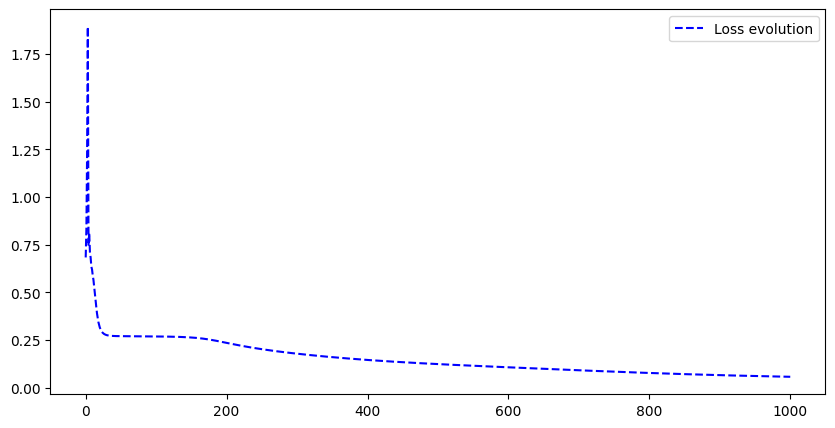

In [12]:
plt.figure(figsize = (10, 5))
plt.plot(list(range(len(shallow_neural_net_pt.loss_history))), \
         shallow_neural_net_pt.loss_history, "b--", label = "Loss evolution")
plt.legend(loc = "best")
plt.show()

In [13]:
def find_v2(v1, model, min_val, max_val, thr = 1e-3):
    # Dichotomic search, to be used for boundary drawing later
    v2_min = min_val
    v2_max = max_val
    while((v2_max - v2_min) > thr):
        v2_avg = (v2_max + v2_min)/2
        x = torch.tensor([v1, v2_avg]).to(device)
        out = model.forward(x).item()
        if(out > 0.5):
            v2_max = v2_avg
        else:
            v2_min = v2_avg
    return (v2_max + v2_min)/2

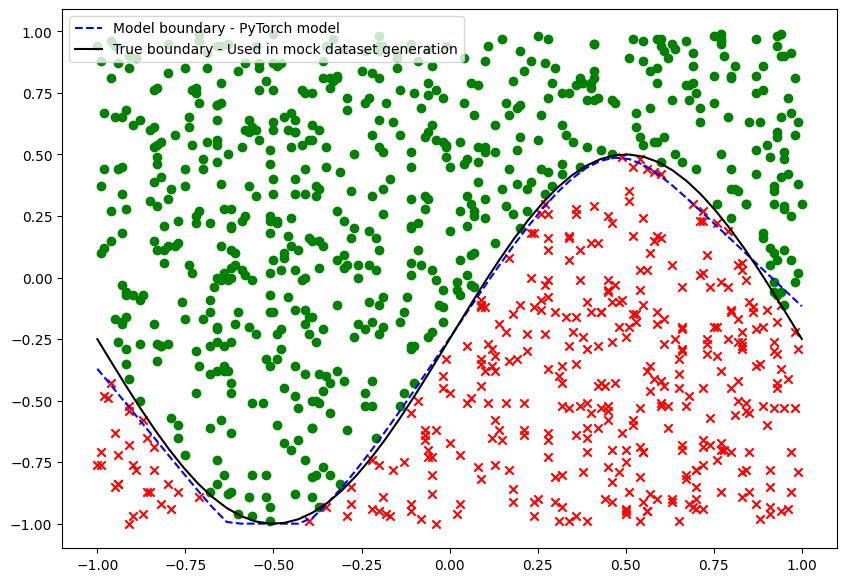

In [14]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "r", 1: "g"}
indexes_0 = np.where(train_outputs == 0)[0]
v1_0 = train_val1_list[indexes_0]
v2_0 = train_val2_list[indexes_0]
indexes_1 = np.where(train_outputs == 1)[0]
v1_1 = train_val1_list[indexes_1]
v2_1 = train_val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display model boundary (PyTorch model)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_act = [find_v2(torch.tensor([v1]).to(device), shallow_neural_net_pt, \
                        min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_act, "b--", label = "Model boundary - PyTorch model")

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - Used in mock dataset generation")

# Show
plt.legend(loc = "best")
plt.show()

### What's next?

In the next notebook, we will investigate how to implement the backpropagation mechanism using the PyTorch framework, and eventually use it to train our model.